<h1 align="center"> Image Captioning </h1> 



Нужно скачать датасет, в нем уже построенны признаки для изображений с помошью GoogleNet.

```bash
!curl -o ./files/coco_with_cnn_features.pkl https://goo.gl/SU8bi7```

In [1]:
# Import all staff

import json
import pickle
import random
import theano
import lasagne
import sklearn
import numpy as np
import skimage.transform
import theano.tensor as T
import matplotlib.pyplot as plt

from time import time
from utils import googlenet
from lasagne import layers as ll
from collections import Counter
from lasagne.utils import floatX
from utils.utils import get_data_batch, prep_batch_for_network

%matplotlib inline

### Подготовка данных

In [2]:
# Read Dataset
dataset = pickle.load(open('files/coco_with_cnn_features.pkl', 'rb'))

In [3]:
# Build a Vocabulary
allwords = Counter()
for item in dataset:
    for sentence in item['sentences']:
        allwords.update(sentence['tokens'])

vocab  = ['#START#', '#END#']
vocab += [k for k, v in allwords.items() if v >= 5]

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for i, w in enumerate(vocab)}

In [4]:
# Define of different constant 
EMBED = 256
BATCH_SIZE = 100
SEQUENCE_LENGTH = 10
CNN_FEATURE_SIZE = 1000
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token

### Ваша модель

In [5]:
# =============================================================
# ================== Define Neural Net Model ==================
# =============================================================

x_img, x_snt, y_snt, mask = T.matrix(), T.imatrix(), T.imatrix(), T.imatrix()

# Input Layer for words 
embed_snt = ll.InputLayer((None, SEQUENCE_LENGTH - 1), x_snt)
embed_snt = ll.EmbeddingLayer(embed_snt, len(vocab), EMBED)

# Input Layer for image features
embed_img = ll.InputLayer((None, CNN_FEATURE_SIZE), x_img)
embed_img = ll.DenseLayer(embed_img, num_units=EMBED, nonlinearity=lasagne.nonlinearities.identity)
embed_img = ll.ReshapeLayer(embed_img, ([0], 1, [1]))

# Concatinate image features and word embedings in one sequence 
rnn_in = ll.ConcatLayer([embed_img, embed_snt])
rnn_in = ll.DropoutLayer(rnn_in, 0.5)

# Make a recurent part 
rnn = lasagne.layers.LSTMLayer(rnn_in, EMBED, grad_clipping=5., unroll_scan=True,)

rnn_out = ll.DropoutLayer(rnn, 0.5)
rnn_out = lasagne.layers.ReshapeLayer(rnn_out, (-1, EMBED))

# Decoding of rnn hiden states
decoder = lasagne.layers.DenseLayer(rnn_out, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)
decoder = lasagne.layers.ReshapeLayer(decoder, (-1, SEQUENCE_LENGTH, len(vocab)))

In [6]:
def calc_cross_ent(net_output, mask, targets):
    preds, targets = T.reshape(net_output, (-1, len(vocab))), T.flatten(targets)
    cost = T.nnet.categorical_crossentropy(preds, targets)[T.flatten(mask).nonzero()]
    return cost

output = ll.get_output(decoder, deterministic=False)
train_loss = T.mean(calc_cross_ent(output, mask, y_snt))

all_params = ll.get_all_params(decoder)
updates = lasagne.updates.adam(train_loss, all_params, learning_rate=0.01)

output = ll.get_output(decoder, deterministic=True)
test_loss = T.mean(calc_cross_ent(output, mask, y_snt))

In [7]:
f_train = theano.function([x_img, x_snt, mask, y_snt], train_loss, updates=updates)
f_val   = theano.function([x_img, x_snt, mask, y_snt], test_loss)

In [9]:
import random
import numpy as np
from lasagne.utils import floatX

MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

# Returns a list of tuples (cnn features, list of words, image ID)
def get_data_batch(dataset, size, sl, split='train'):
    items = []
    
    while len(items) < size:
        item = random.choice(dataset)
        if item['split'] != split:
            continue
        sentence = random.choice(item['sentences'])['tokens']
        if len(sentence) > sl:
            continue
        items.append((item['cnn features'], sentence, item['cocoid']))
    
    return items

# Convert a list of tuples into arrays that can be fed into the network
def prep_batch_for_network(batch, sl):
    x_cnn = floatX(np.zeros((len(batch), 1000)))
    x_sentence = np.zeros((len(batch), sl - 1), dtype='int32')
    y_sentence = np.zeros((len(batch), sl), dtype='int32')
    mask = np.zeros((len(batch), sl), dtype='bool')

    for j, (cnn_features, sentence, _) in enumerate(batch):
        x_cnn[j] = cnn_features
        i = 0
        for word in ['#START#'] + sentence + ['#END#']:
            if word in word_to_index:
                mask[j, i] = True
                y_sentence[j, i] = word_to_index[word]
                x_sentence[j, i] = word_to_index[word]
                i += 1
                
    return x_cnn, x_sentence, y_sentence, mask

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

In [10]:
loss_train, norm, st = 0, 0, time()
for iteration in range(0, 2000):
    print '.',
    batch = prep_batch_for_network(get_data_batch(dataset, BATCH_SIZE, MAX_SENTENCE_LENGTH), SEQUENCE_LENGTH)
    x_cnn, x_sentence, y_sentence, mask = batch
    loss_train += f_train(x_cnn, x_sentence, mask, y_sentence)
    if not iteration % 40:
        print int(time() - st), 'sec.',
        st = time()
        
        batch = get_data_batch(dataset, BATCH_SIZE, MAX_SENTENCE_LENGTH, split='val')
        x_cnn, x_sentence, y_sentence, mask = prep_batch_for_network(batch, SEQUENCE_LENGTH)
        loss_val = f_val(x_cnn, x_sentence, mask, y_sentence)
        print('\nIt: {}, loss_train: {}, val loss: {}'.format(iteration, loss_train/40, loss_val))
        loss_train, norm = 0, 0
        
print 'Finish =)'

. 3 sec. 
It: 0, loss_train: 0.231084913406, val loss: 9.18301430849
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 111 sec. 
It: 40, loss_train: 5.05715865414, val loss: 4.16006153752
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 97 sec. 
It: 80, loss_train: 3.95085937178, val loss: 3.98466799583
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 87 sec. 
It: 120, loss_train: 3.50831163545, val loss: 3.60610405055
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 94 sec. 
It: 160, loss_train: 3.23697698369, val loss: 3.51093113512
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 108 sec. 
It: 200, loss_train: 2.99173714747, val loss: 3.31208417727
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 88 sec. 
It: 240, loss_train: 2.80639464822, val loss: 3.52994622131
. . . . . . . . . . . . . . . . . . .

### Применение модели

In [11]:
# Загрузим сеть
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

gnw = pickle.load(open('files/blvc_googlenet.pkl'))
CLASSES = np.array(gnw['synset words'])
lasagne.layers.set_all_param_values(cnn_output_layer, gnw['param values'])

In [12]:
im = plt.imread('./files/Dog-and-Cat.jpg')
rawim, cnn_im = prep_image(im)

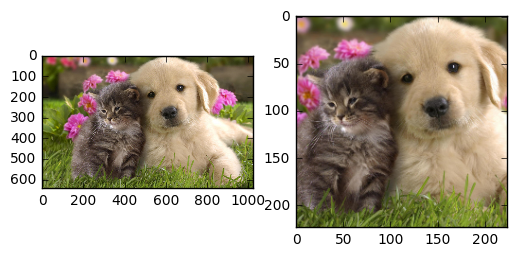

In [13]:
plt.subplot(121); plt.imshow(im);
plt.subplot(122); plt.imshow(rawim);

In [14]:
# Выведим самые вероятные классы
p = get_cnn_features(cnn_im)
max_prob_idx = p.argsort()[0][-5:]

for i in reversed(max_prob_idx):
    print CLASSES[i], p[0][i]

hamster 11.2842030641
Angora, Angora rabbit 10.8251621937
Persian cat 10.1706908479
guinea pig, Cavia cobaya 9.29974247167
Pekinese, Pekingese, Peke 8.50792234387


In [15]:
# Получим функцию для генепации следующего слова
output = ll.get_output(decoder, deterministic=False)
f = theano.function([x_img, x_snt], output)

In [16]:
def predict(x_cnn):
    x_sentence = np.zeros((1, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            return ' '.join(words)
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

In [17]:
x_cnn = get_cnn_features(cnn_im)

In [18]:
# Sample some predictions
for _ in range(10):
    print(predict(x_cnn))

a cat sits on a tiled stand
a cat sitting in a glass blanket
a cheese pizza containing carrots and cabbage
a plate of food on a table
a cat sits on a tiled desk
a cat is sleeping on the couch
a happy is eating a chocolate salad
a dog is sleeping on a rug
a person is holding a frosted cake
a cat sitting on a television set
